In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [4]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
da_ = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_, save_da=True)
exp_summer = Experiment(dh_summer)
nx, ny, metric = 4, 4, "euclidean"
net, centers, labels = exp_summer.som_cluster(
    4,
    4,
    200,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
    activation_distance=metric,
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates

ds_center_path = exp_summer.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season == "JJA")
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_summer.da.time, "cluster": np.arange(net.n_nodes)})

100%|██████████| 16/16 [00:00<00:00, 317.95it/s]


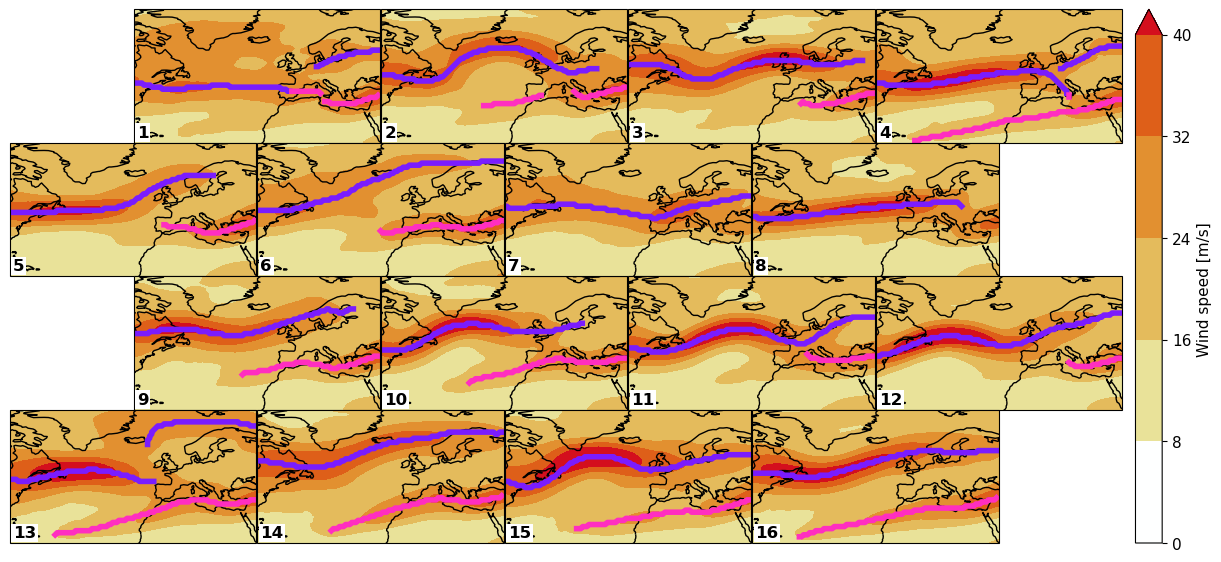

In [5]:
ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=18, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "lev"), n_components=2, n_init=40, mode="year")

new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(pl.col("jet ID") + (pl.col("is_polar") > 0.5).cast(pl.UInt16).diff().abs().fill_null(0).cum_sum().cast(pl.UInt32) * njets)
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

centers_props_uncat = compute_jet_props(centers_all_jets)
centers_props = average_jet_categories(centers_props_uncat, polar_cutoff=0.5)

clu = Clusterplot(net.y, net.x, get_region(da), honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    # transparify=1,
    levels=[0, 8, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.35
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
clu.resize_relative([0.95, 1])
# plt.savefig(f'{FIGURES}/som_composites/wind_and_jets.png')

In [6]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.x
    maxdy = net.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

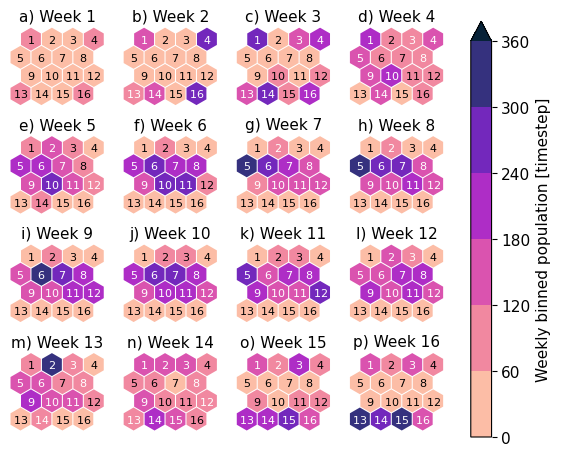

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(TEXTWIDTH_IN, 5.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
max_ = np.quantile([np.amax(timestepwis[3]) for timestepwis in timestepwise], 0.8)
norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("Weekly binned population [timestep]")
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    letter = ascii_lowercase[i]
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        linewidths=0,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"{letter}) Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        color = "white" if to_plot[i] > 100 else "black"
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=8)
fig.set_tight_layout(False)

In [8]:
from scipy.stats import linregress
from sklearn.metrics import pairwise_distances

da = exp_summer.da
yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )

X, da_weighted = exp_summer.prepare_for_clustering()
X = exp_summer.pca_transform(X, 200)
X = compute(X, progress_flag=True)

RMSE = np.zeros(net.n_nodes)
for i in trange(net.n_nodes):
    w = net.weights[i].flatten()[None, :]
    mask_ = labels.data == i
    x = X[mask_] .reshape(np.sum(mask_), -1) 
    RMSE[i] = np.mean(pairwise_distances(x, w))
    
from sklearn.metrics import pairwise_distances
separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances
separatedness = np.nanmean(separatedness, axis=1)

100%|██████████| 16/16 [00:00<00:00, 619.63it/s]
/scratch/local/17492984/ipykernel_1544445/3689265167.py:25: RuntimeWarning: invalid value encountered in divide
  separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances


In [9]:
da_z = open_da("ERA5", "plev", "z", "6H", "all", None, -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 90)}, None)
da_z = da_z.sel(time=summer.to_numpy())
# dh_z = DataHandler.from_basepath_and_da("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/z/6H/dayofyear_doywin90/results", da_z, save_da=True)

In [10]:
# da_z = open_da("ERA5", "plev", "z", "6H", "all", None, -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 90)}, None)
# da_z = da_z.sel(time=summer.to_numpy())
# dh_z = DataHandler.from_basepath_and_da("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/z/6H/dayofyear_doywin90/results", da_z, save_da=True)
dh_z = DataHandler("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/z/6H/dayofyear_doywin90/results/1")
exp_z = Experiment(dh_z)
centers_z, labels_z = exp_z.do_kmeans(4, 30, weigh_grams=False)

coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (exp_z.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]
Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr, progress_flag=True)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("time").dt.year().alias("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > sigma_wr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")
to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())

s_and_z = (mask[:, :, None] & mask_updated[:, None, :])

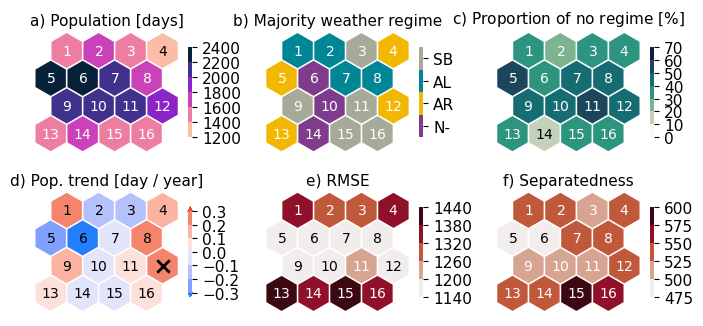

In [11]:
titles_wr = [
    "N-",
    "AR",
    "AL",
    "SB",
    "No regime",
]
order_to_plot = [1, 2, 3, 4, 0]
titles_wr_with_props = [fr"{letter}) {title}, (${prop * 100:.1f} \%$)" for letter, title, prop in zip(list("efghi"), titles_wr, mask_updated.mean(axis=0)[order_to_plot])]
s_and_z_means = s_and_z.mean(axis=0) / mask.mean(axis=0)[:, None]
s_and_z_means = s_and_z_means[:, order_to_plot]
majority = np.argmax(s_and_z_means[:, :4], axis=1)
no_regime = mask_updated.mean(axis=0)[0]

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN , 2 * 1.7), tight_layout=True, subplot_kw=dict(aspect="equal"))

to_plot_dict = {
    "a) Population [days]": (populations, colormaps.bubblegum_r, True, True, {}),
    # "b) Majority weather regime": (majority, colormaps.bold, BoundaryNorm(np.arange(-0.5, 4.5), colormaps.bold.N, extend="neither"), True, {"ticks": np.arange(4), "ticklabels": titles_wr[:-1]}),
    "b) Majority weather regime": (majority, colormaps.bold, False, True, {"ticks": np.arange(4), "ticklabels": titles_wr[:-1], "boundaries": np.arange(-0.5, 4.5)}),
    r"c) Proportion of no regime [$\%$]": (s_and_z_means[:, -1] * 100, colormaps.tempo, BoundaryNorm(np.arange(0, 80, 10), colormaps.tempo.N, extend="neither"), True, {}),
    "d) Pop. trend [day / year]": (trends, colormaps.cet_d_bwr, BoundaryNorm(np.linspace(-0.3, 0.3, 7), colormaps.cet_d_bwr.N, extend="both"), False, {}),
    "e) RMSE": (RMSE, colormaps.amp, True, True, {}),
    "f) Separatedness" : (separatedness, colormaps.amp, True, True, {}),
} 
for ax, (title, to_plot) in zip(axes.ravel(), to_plot_dict.items()):
    to_plot, cmap, discretify, numbering, more_cbar_kwargs = to_plot
    if isinstance(discretify, bool):
        discretify = discretify
        norm = None
    else:
        norm = discretify
        discretify = False
    fig, ax = net.plot_on_map(
        to_plot,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        discretify=discretify,
        numbering=numbering,
        cbar_kwargs={"shrink": 0.7} | more_cbar_kwargs
    )
    ax.set_title(title)
    
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
ax = axes.ravel()[3]
ax.scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
for i, c in enumerate(coords):
    x, y = c
    if i in where_signif:
        continue
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=10)
# fig.savefig(f'{FIGURES}/som_props/fig06_new.png')

In [12]:
from xpysom_dask.diagnostics import *
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(net.weights)
sigma = np.quantile(distances[distances > 0], 0.1)
spells_above_4 = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=16, nojune=False)
spells_any = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=1, nojune=False)

spells_per_cluster = spells_above_4.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
n_stays = spells_per_cluster["len"].to_numpy()

mean_len_per_cluster = spells_any.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
mean_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(mean_len_per_cluster, how="left", on="value")
mean_len = mean_len_per_cluster["len"].to_numpy() / 4

max_len_per_cluster = spells_any.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").quantile(0.95))
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
max_len = max_len_per_cluster["len"].to_numpy() / 4

plot_on_map = [
    {
        "title": r"\# of long stays ($> 4$ days)",
        "data": n_stays,
        "cmap": colormaps.bubblegum_r,
    },
    {
        "title": "Mean residence time [day]",
        "data": mean_len,
        "cmap": colormaps.bubblegum_r,
    },
    {
        "title": "$Q_{95}$ of residence times [day]",
        "data": max_len,
        "cmap": colormaps.bubblegum_r,
    },
]

ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=18, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "lev"), n_components=2, n_init=40, mode="year")

new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(pl.col("jet ID") + (pl.col("is_polar") > 0.5).cast(pl.UInt16).diff().abs().fill_null(0).cum_sum().cast(pl.UInt32) * njets)
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

centers_props_uncat = compute_jet_props(centers_all_jets)
centers_props = average_jet_categories(centers_props_uncat, polar_cutoff=0.5)

jet_pos_da_centers = jet_position_as_da(centers_all_jets)
centers_props = get_double_jet_index(centers_props, jet_pos_da_centers)
centers_props = centers_props.with_columns(centers_props["tilt"].clip(0, 1))

props_as_df_summer = props_as_df.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()))

data_vars_and_jets = [
    ("persistence", "STJ", colormaps.flamingo_r),
    ("persistence", "EDJ", colormaps.gothic_r),
    ("com_speed", "STJ", colormaps.flamingo),
    ("com_speed", "EDJ", colormaps.gothic),
]

for (varname, jet, cmap) in data_vars_and_jets:
    title = f"{jet} {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]"
    data = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    data = timeseries_on_map(data, net.latest_bmus)[0]
    dico = {
        "title": title,
        "data": data,
        "cmap": cmap,
    }
    plot_on_map.append(dico)

100%|██████████| 16/16 [00:00<00:00, 510.85it/s]


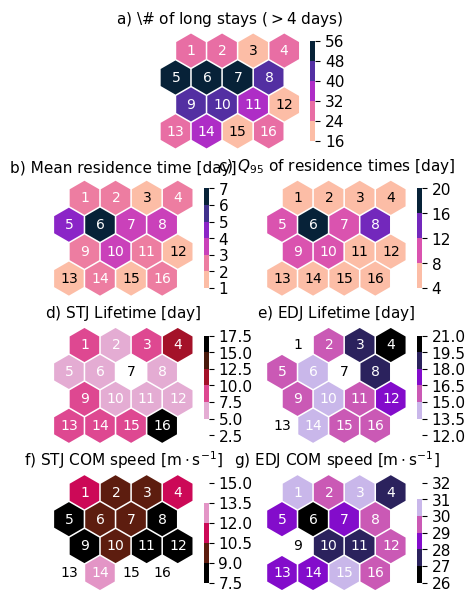

In [13]:
# fig, axes = plt.subplots(4, 2, figsize=(TEXTWIDTH_IN * 0.66, 3.9), tight_layout=True, gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), subplot_kw=dict(aspect="equal"))
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(TEXTWIDTH_IN * 0.63, 5.9))
gs = GridSpec(4, 4, wspace=0.03, hspace=0.18, bottom=0.02, top=0.98, left=0.02, right=0.98)
axes = np.empty(7, dtype=object)
subplot_kw=dict(aspect="equal")
axes[0] = fig.add_subplot(gs[0, slice(1, 3)], **subplot_kw)
for i in range(1, 7):
    iprim = ((i + 1) % 2) * 2
    axes[i] = fig.add_subplot(gs[1 + (i - 1) // 2, slice(0 + iprim, 2 + iprim)], **subplot_kw)
fig.set_tight_layout(False)
axes = axes.ravel()
for ax, dico, letter in zip(axes, plot_on_map, "abcdefg"):
    title = dico["title"]
    fig, ax = net.plot_on_map(
        **dico,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
    ax.set_title(f"{letter}) {title}")
fig.set_tight_layout(False)
# fig.savefig(f'{FIGURES}/som_props/residence_newnew.png')

In [23]:
ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=18, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "lev"), n_components=2, n_init=40, mode="year")


new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(pl.col("jet ID") + (pl.col("is_polar") > 0.5).cast(pl.UInt16).diff().abs().fill_null(0).cum_sum().cast(pl.UInt32) * njets)
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

centers_props_uncat = compute_jet_props(centers_all_jets)
widths = compute_widths(centers_all_jets, ds_center["s"])
centers_props_uncat = centers_props_uncat.join(widths, on=["cluster", "jet ID"]).sort("cluster", "jet ID")
centers_props = average_jet_categories(centers_props_uncat, polar_cutoff=0.1)

jet_pos_da_centers = jet_position_as_da(centers_all_jets)
centers_props = get_double_jet_index(centers_props, jet_pos_da_centers)
centers_props = centers_props.with_columns(centers_props["tilt"].clip(0, 1))

100%|██████████| 16/16 [00:00<00:00, 389.54it/s]


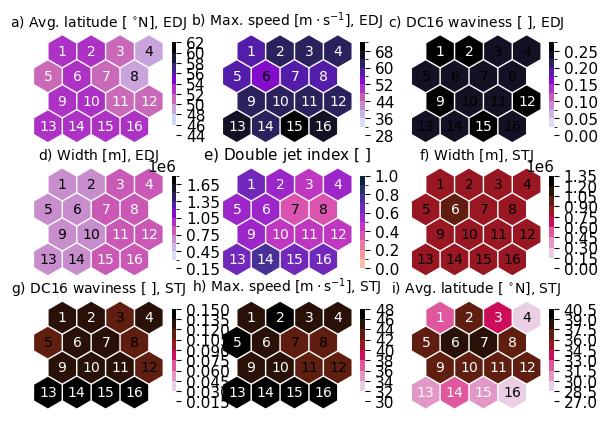

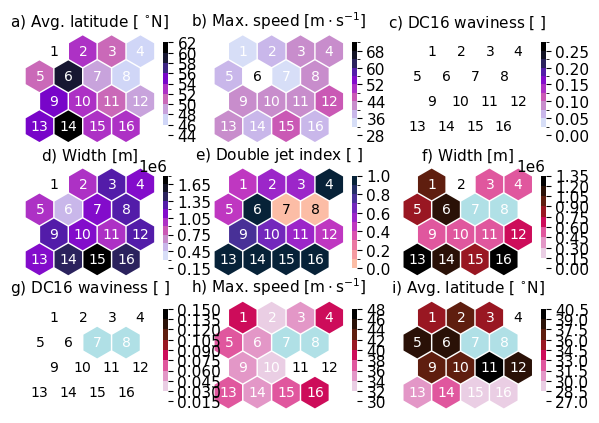

In [27]:
from string import ascii_lowercase

data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("width", "EDJ"),
    ("double_jet_index", "STJ"),
    ("width", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]
fig1, axes1 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 3.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes1 = axes1.flatten()
fig2, axes2 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 3.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes2 = axes2.flatten()
for letter, (varname, jet), (j, ax1) in zip(ascii_lowercase, data_vars_and_jets, enumerate(axes1)):
    ax2 = axes2[j]
    if varname == "double_jet_index":
        cmap = colormaps.bubblegum_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = colormaps.gothic_r if jet == "EDJ" else colormaps.flamingo_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot_1 = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    to_plot_1 = timeseries_on_map(to_plot_1, net.latest_bmus)[0]
    to_plot_2 = centers_props.filter(pl.col("jet") == jet)[varname].to_numpy()
    feature = np.concatenate([to_plot_1, to_plot_2])
    symmetric = infer_direction(np.nan_to_num(feature)) == 0
    levels = MaxNLocator(14 if symmetric else 10, symmetric=symmetric).tick_values(np.nanmin(feature), np.nanmax(feature))
    norm = BoundaryNorm(levels, cmap.N)
    cmap.set_bad(color="powderblue")
    fig1, ax1 = net.plot_on_map(
        to_plot_1,
        smooth_sigma=0,
        show=False,
        fig=fig1,
        ax=ax1,
        draw_cbar=True,
        cmap=cmap,
        norm=norm,
        discretify=False,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
    fig2, ax2 = net.plot_on_map(
        np.ma.masked_invalid(to_plot_2),
        smooth_sigma=0,
        show=False,
        fig=fig2,
        ax=ax2,
        draw_cbar=True,
        cmap=cmap,
        norm=norm,
        discretify=False,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
# fig1.savefig(f'{FIGURES}/som_props/combined_indices_same_cbar.png')
# fig2.savefig(f'{FIGURES}/som_props/combined_indices_on_map_same_cbar.png')

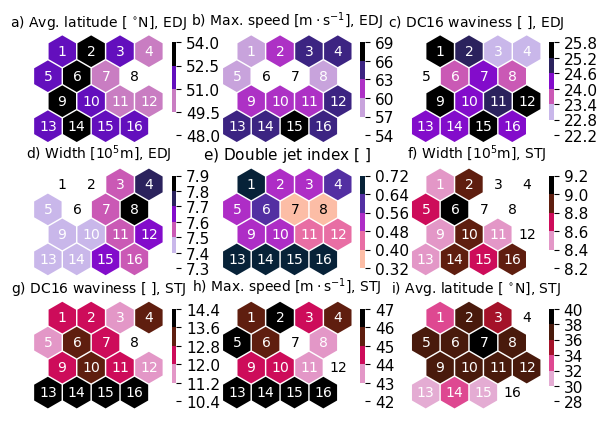

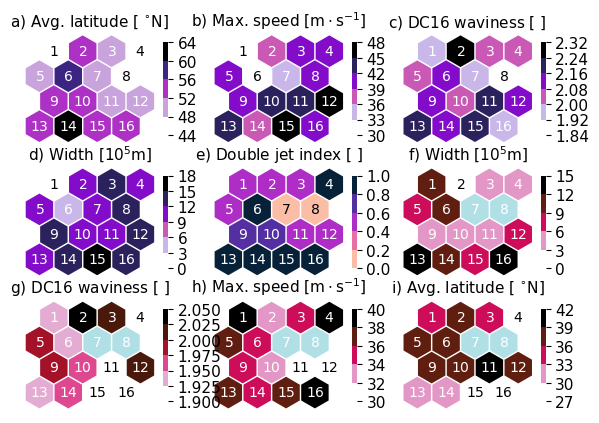

In [29]:
from string import ascii_lowercase

data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("width", "EDJ"),
    ("double_jet_index", "STJ"),
    ("width", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]
fig1, axes1 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 3.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes1 = axes1.flatten()
fig2, axes2 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 3.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes2 = axes2.flatten()
for letter, (varname, jet), (j, ax1) in zip(ascii_lowercase, data_vars_and_jets, enumerate(axes1)):
    ax2 = axes2[j]
    if varname == "double_jet_index":
        cmap = colormaps.bubblegum_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    elif varname == "width":
        cmap = colormaps.gothic_r if jet == "EDJ" else colormaps.flamingo_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [$10^5${UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [$10^5${UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = colormaps.gothic_r if jet == "EDJ" else colormaps.flamingo_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot_1 = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    to_plot_1 = timeseries_on_map(to_plot_1, net.latest_bmus)[0]
    to_plot_2 = centers_props.filter(pl.col("jet") == jet)[varname].to_numpy()
    if varname == "width":
        to_plot_1 = to_plot_1 / 1e5
        to_plot_2 = to_plot_2 / 1e5
    if varname == "wavinessDC16":
        to_plot_1 = to_plot_1 * 1e2
        to_plot_2 = to_plot_2 * 1e2
    feature = np.concatenate([to_plot_1, to_plot_2])
    symmetric = infer_direction(np.nan_to_num(feature)) == 0
    levels = MaxNLocator(10 if symmetric else 6, symmetric=symmetric).tick_values(np.nanmin(feature), np.nanmax(feature))
    norm = BoundaryNorm(levels, cmap.N)
    cmap.set_bad(color="powderblue")
    fig1, ax1 = net.plot_on_map(
        to_plot_1,
        smooth_sigma=0,
        show=False,
        fig=fig1,
        ax=ax1,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
    fig2, ax2 = net.plot_on_map(
        np.ma.masked_invalid(to_plot_2),
        smooth_sigma=0,
        show=False,
        fig=fig2,
        ax=ax2,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
# fig1.savefig(f'{FIGURES}/som_props/combined_indices.png')
# fig2.savefig(f'{FIGURES}/som_props/combined_indices_on_map.png')